<a href="https://colab.research.google.com/github/RonTeichner/IRASforBacteria/blob/main/IRAS_for_Bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IRAS for Bacteria - Ornstein-Uhlenbeck**

First we simulate the Ornstein-Uhlenbeck (OU) stochastic process for the cell-size division mechanism

$$
\begin{equation}
dc = \frac{\mu_c-c}{\tau_c}dt + \sqrt{2\frac{\sigma^2_c}{\tau_c}}dW
\end{equation}
$$
where the term $dW$ is an increment of a Wiener process and with $\mu_c=1\, \mathrm{[\mu m]}$, $\sigma_c=0.1\, \mathrm{[\mu m]}$ and $\tau_c$ is either $2,40$ or $200\, \mathrm{[min]}$. Initial conditions are $c(0) \sim N(\mu_c, \sigma_c^2)$.





In [ ]:
#!pip install torchsde
import torch
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchsde
from scipy import interpolate

class SDE_1D(nn.Module):

    def __init__(self, mu_c, sigma_c, tau_c):
        super().__init__()
        self.mu_c = nn.Parameter(torch.tensor(mu_c), requires_grad=False)
        self.sigma_c = nn.Parameter(torch.tensor(sigma_c), requires_grad=False)
        self.tau_c = nn.Parameter(torch.tensor(tau_c), requires_grad=False)
        self.WienerGain = nn.Parameter(torch.sqrt(2*torch.pow(self.sigma_c, 2)/self.tau_c), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, c):
        return (self.mu_c - c)/self.tau_c

    def g(self, t, c):
        return self.WienerGain*torch.ones_like(c)

mu_c, sigma_c = 1.0, 0.1 # [mu m]
tau_cs = [2, 40, 200] # [min]

batch_size, state_size = 100, 1
nGenerations = 100
nMinPerGeneration = 60.0
t_step, sim_duration = 1.0/60*10, nMinPerGeneration*nGenerations # [min]
sde_sizer = SDE_1D(mu_c, sigma_c, tau_cs[0])
sde_adder = SDE_1D(mu_c, sigma_c, tau_cs[1])
sde_timer = SDE_1D(mu_c, sigma_c, tau_cs[2])
ts = np.arange(0, sim_duration, t_step)
c0 = mu_c + sigma_c*torch.randn(batch_size, state_size)

sys.setrecursionlimit(5000)

with torch.no_grad():
    cs_sizer = torchsde.sdeint(sde_sizer, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()
    cs_adder = torchsde.sdeint(sde_adder, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()
    cs_timer = torchsde.sdeint(sde_timer, c0, torch.from_numpy(ts), adaptive=False, dt=0.1).cpu().numpy()



Let us view 3 OU processes from each $\tau_c$:

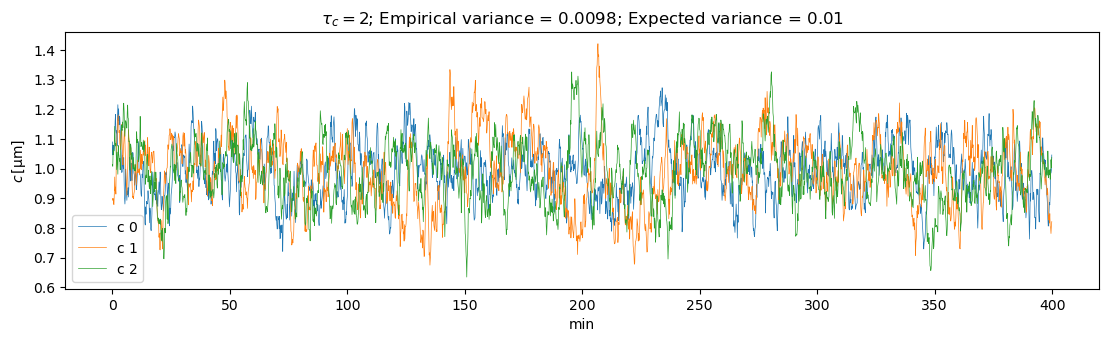

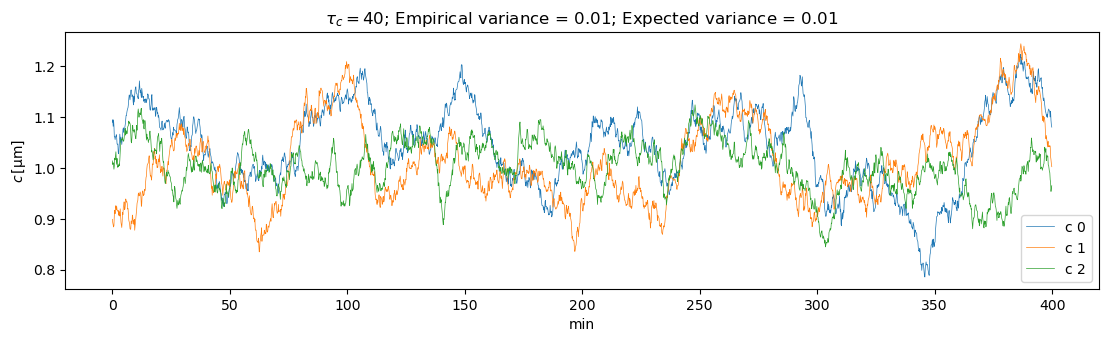

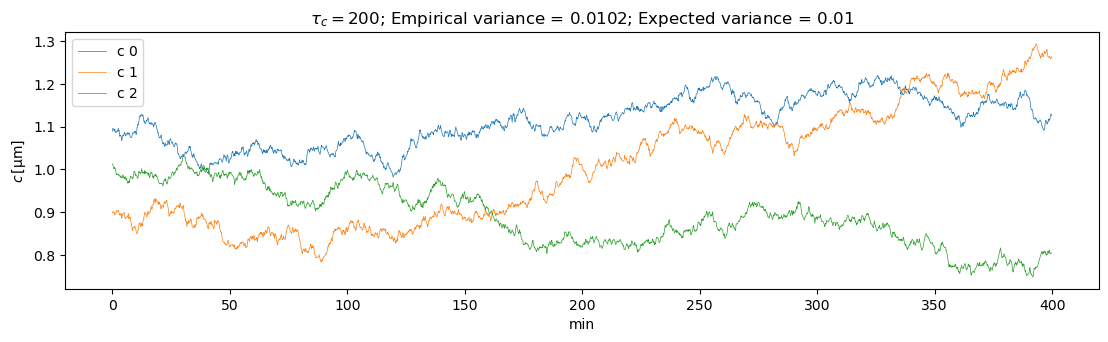

In [ ]:
def plot(ts, samples, xlabel, ylabel, title=''):
    samples = np.transpose(samples[:,:,0])
    plt.figure(figsize=(20/1.5,5/1.5))
    for i, sample in enumerate(samples):
        plt.plot(ts, sample[:len(ts)], linewidth = 0.5, label=f'c {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

nMin2Plot = 400
titleStr = r'$\tau_c=$' + f'{tau_cs[0]}; Empirical variance = {str(round(cs_sizer.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_sizer[:,:3], xlabel='min', ylabel='$c\, \mathrm{[\mu m]}$', title=titleStr)

titleStr = r'$\tau_c=$' + f'{tau_cs[1]}; Empirical variance = {str(round(cs_adder.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_adder[:,:3], xlabel='min', ylabel='$c\, \mathrm{[\mu m]}$', title=titleStr)

titleStr = r'$\tau_c=$' + f'{tau_cs[2]}; Empirical variance = {str(round(cs_timer.flatten().var(), 4))}; Expected variance = {str(round(sigma_c**2,4))}'
plot(ts[:int(nMin2Plot/t_step)], cs_timer[:,:3], xlabel='min', ylabel=r'$c\, \mathrm{[\mu m]}$', title=titleStr)

Next, we simulate lineages, each containing $100$ cells where the n<sup>th </sup> cell in the l<sup>th </sup> lineage ($n>0$) grows according to
$$
\begin{equation}
\begin{split}
x_n^{(l)}(t_{n,b}^{(l)} \leq t \leq t_{n,d}^{(l)}) &= x_{n,b}^{(l)} e^{\alpha_n (t-t_{n,b}^{(l)})}, \quad \alpha_n \sim \Gamma(25,9.4\cdot 10^{-4})\\
x_{n,b}^{(l)} &= x_{n-1}^{(l)}(t_{n-1,d}^{(l)})f_n, \quad f_n \sim N(0.5,0.05^2)\\
t_{n,b}^{(l)} &= t_{n-1,d}^{(l)}\\
t_{n,d}^{(l)} &= \mathrm{argmin}_t\{t \geq t_{n,b}^{(l)} \mid x_{n,b}^{(l)} e^{\alpha (t-t_{n,b}^{(l)})} = c^{(l)}(t)\},
\end{split}
\end{equation}
$$
where $x_{n,b}^{(l)}\overset{\Delta}{=}x_n^{(l)}(t_{n,b}^{(l)})$ and the initial conditions for the first cell are
$$
\begin{equation}
\begin{split}
x_{0,b}^{(l)} &\sim N(0.5, 0.05^2), \quad
t_{0,b}^{(l)} = 0.
\end{split}
\end{equation}
$$
For each cell we save the features $(x_{n,b}^{(l)} ,x_{n,d}^{(l)}  ,T_n^{(l)} )\overset{\Delta}{=}(x_n^{(l)}(t_{n,b}^{(l)}), x_n^{(l)}(t_{n,d}^{(l)}), t_{n,d}^{(l)}-t_{n,b}^{(l)})$.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install numpy
import numpy as np
#print(f'{np.version.version}')
import pandas as pd
from IPython import display



def saveCSV(data, filename):
  completeFeatures = ['l0.0D','l1.0D','D']
  P, T, F = data.shape[0], data.shape[1], data.shape[2]
  df = pd.DataFrame(columns=["time","Id","batch"] + completeFeatures, data=np.zeros((P*T, 3+F)))
  tVec = np.arange(T)
  for p in range(P):
      specificID = data[p]
      df.loc[p*T:(p+1)*T-1,'time'] = tVec
      df.loc[p*T:(p+1)*T-1,'Id'] = p
      df.loc[p*T:(p+1)*T-1,'batch'] = 0
      df.iloc[p*T:(p+1)*T, 3:3+F] = specificID

  df.to_csv(filename)

def get_divisionTime(xb, t_xb, cs, ts, gamma_shape, gamma_scale, mechanismType):

  #alpha = 0.0235 + (0.0235*0.005)*np.random.randn()
  alpha = np.random.gamma(gamma_shape, gamma_scale)

  x = xb*np.exp(alpha*(ts - t_xb))
  if mechanismType == 'sizer':
    xd_plus_idx = np.where(x >= cs)[0][0]
  elif mechanismType == 'adder':
    xd_plus_idx = np.where(x-xb >= cs)[0][0]
  xd_plus, xd_minus = x[xd_plus_idx], x[xd_plus_idx-1]
  cs_plus, cs_minus = cs[xd_plus_idx], cs[xd_plus_idx-1]
  ts_plus, ts_minus = ts[xd_plus_idx], ts[xd_plus_idx-1]

  ts_highRes = np.arange(ts_minus, ts_plus, 1e-3)
  x_highRes = xd_minus*np.exp(alpha*(ts_highRes-ts_minus))
  cs_highRes = (cs_plus-cs_minus)/(ts_plus-ts_minus)*(ts_highRes-ts_minus) + cs_minus
  t_xd = ts_highRes[np.argmin(np.abs(cs_highRes-x_highRes))]
  xd = xb*np.exp(alpha*(t_xd - t_xb))

  return t_xd, xd

xb_0_mu, xb_0_sigma = 0.5, np.sqrt(0.0025)
f_mu = 0.5
f_sigma = 0.05*f_mu
gamma_shape, gamma_scale = 25, 9.4e-4

for mechanismType in ['adder', 'sizer']:
    for csi, cs_series in enumerate([cs_sizer, cs_adder, cs_timer]):
        observations = np.zeros((batch_size, int(nGenerations), 3)) # xb, xd, T
        for l in range(batch_size):
            display.clear_output(wait=True)
            print(mechanismType + f'; tau={tau_cs[csi]}; lineage {l}')
            single_cs_series = cs_series[:,l,0]
            for g in range(int(nGenerations)):
                if g == 0:
                    xbNegative = True
                    while xbNegative:
                        xb = xb_0_mu + xb_0_sigma*np.random.randn()
                        xbNegative = xb <= 0 or xb >= single_cs_series[0]
                    t_xb = 0.0
                else:
                    f_above_1 = True
                    while f_above_1:
                        f = f_mu + f_sigma*np.random.randn()
                        f_above_1 = f >= 1
                    xb = observations[l, g-1, 1]*f # \mu m
                    t_xb = observations[l, :g, 2].sum() # min
                t_xd, xd = get_divisionTime(xb, t_xb, single_cs_series, ts, gamma_shape, gamma_scale, mechanismType)
                observations[l, g] = np.array([xb, xd, t_xd - t_xb])
        if mechanismType == 'sizer':
            if csi == 0:
                observations_sizer = observations
                saveCSV(observations_sizer, './observations_sizer.csv')
            elif csi == 1:
                observations_adder = observations
                saveCSV(observations_adder, './observations_adder.csv')
            elif csi == 2:
                observations_timer = observations
                saveCSV(observations_timer, './observations_timer.csv')
        elif mechanismType == 'adder':
            if csi == 0:
                observations_adder_small_tau = observations
                saveCSV(observations_adder_small_tau, './observations_adder_small_tau.csv')
            elif csi == 1:
                observations_adder_medium_tau = observations
                saveCSV(observations_adder_medium_tau, './observations_adder_medium_tau.csv')
            elif csi == 2:
                observations_adder_high_tau = observations
                saveCSV(observations_adder_high_tau, './observations_adder_high_tau.csv')

sizer; tau=200; lineage 99


Let us view the OU threshold together with the lineages:

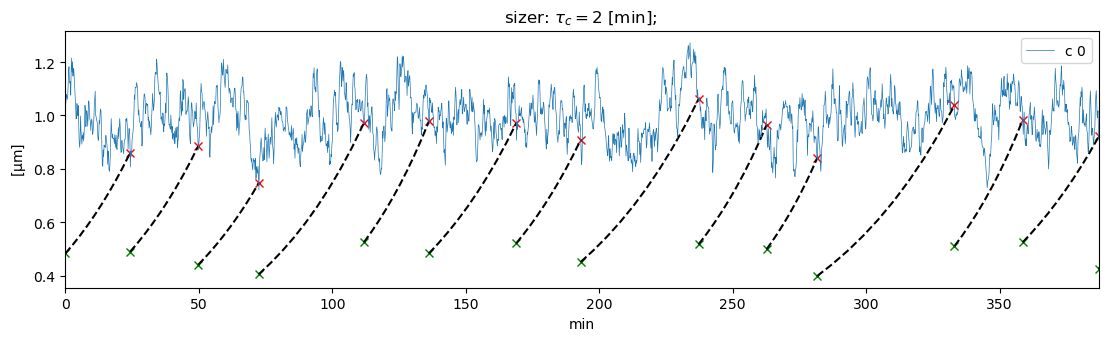

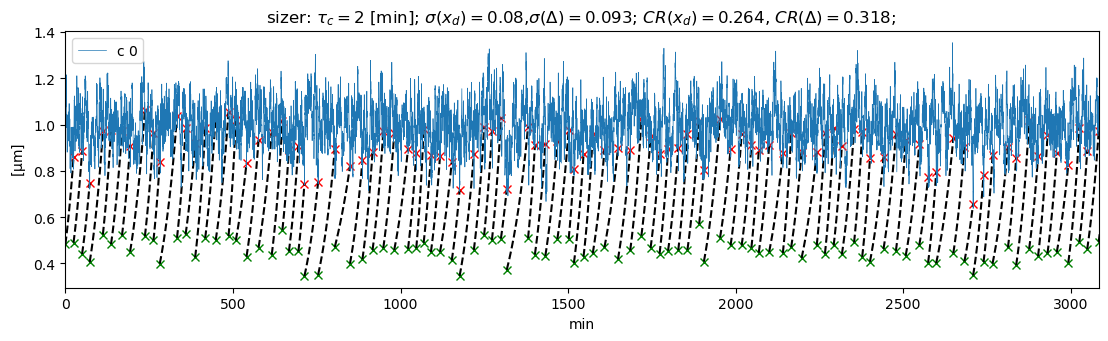

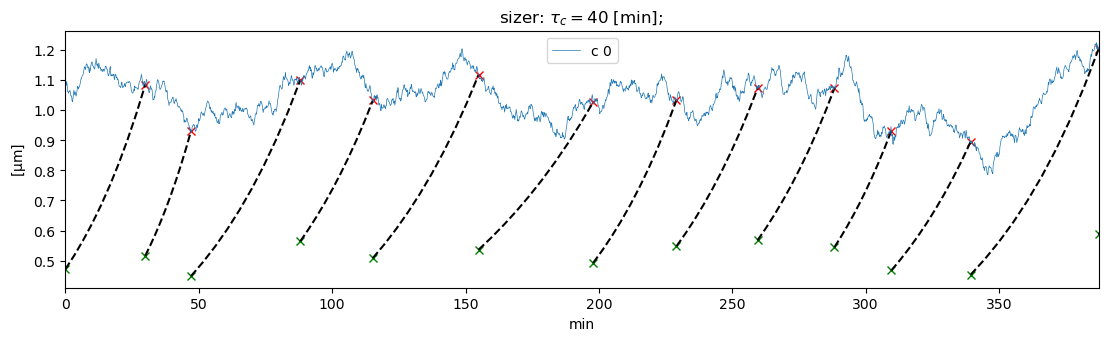

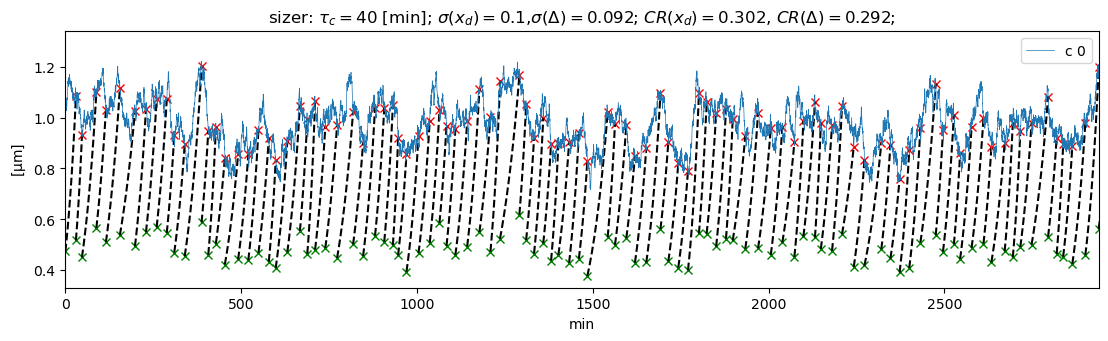

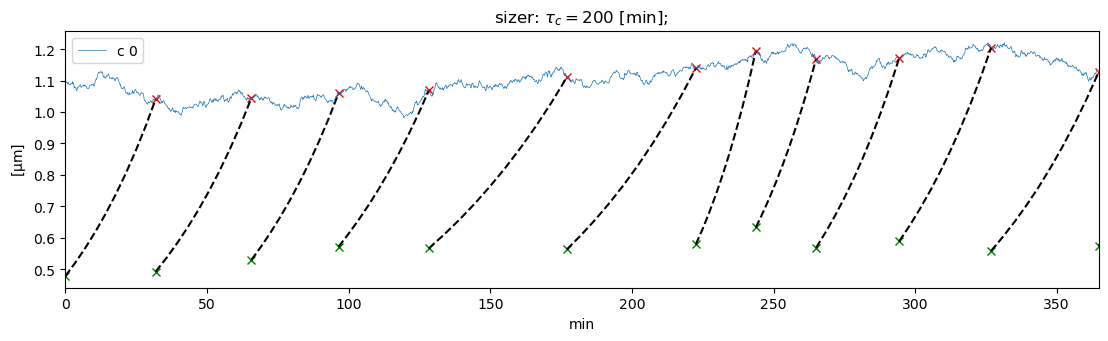

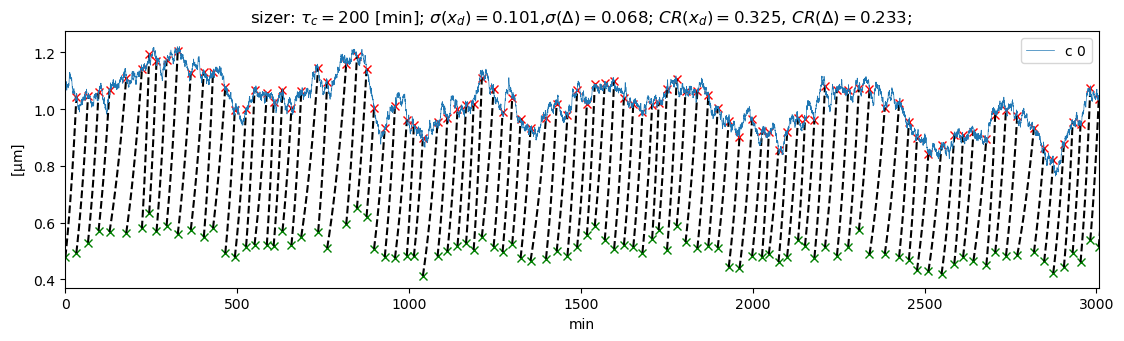

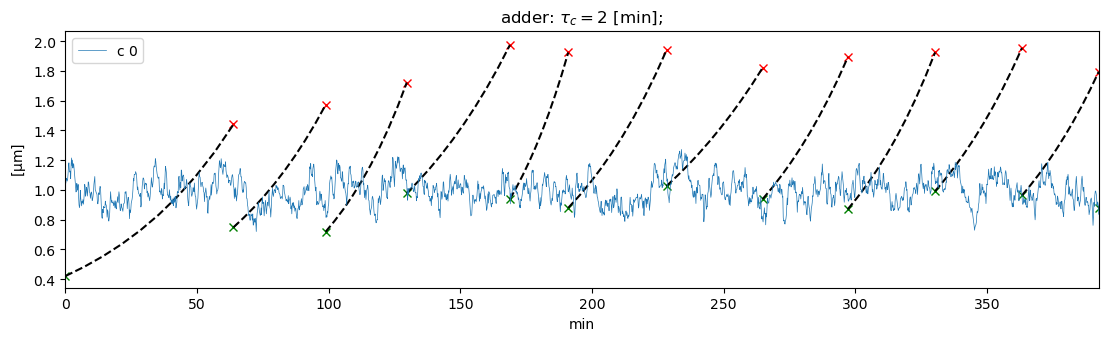

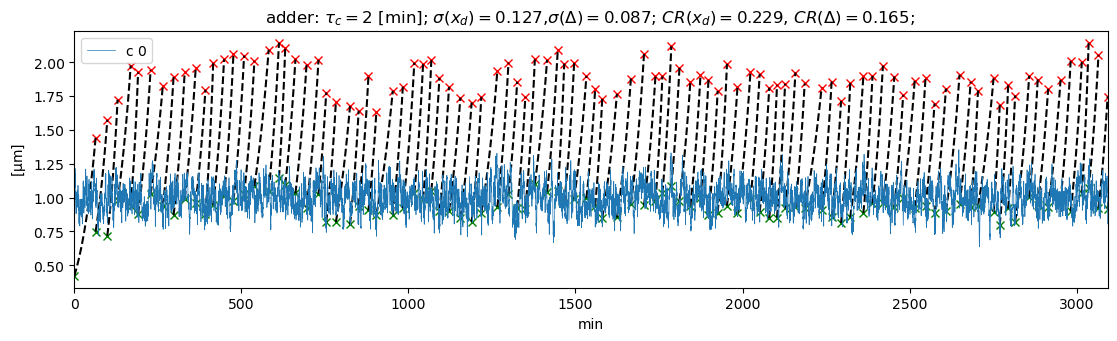

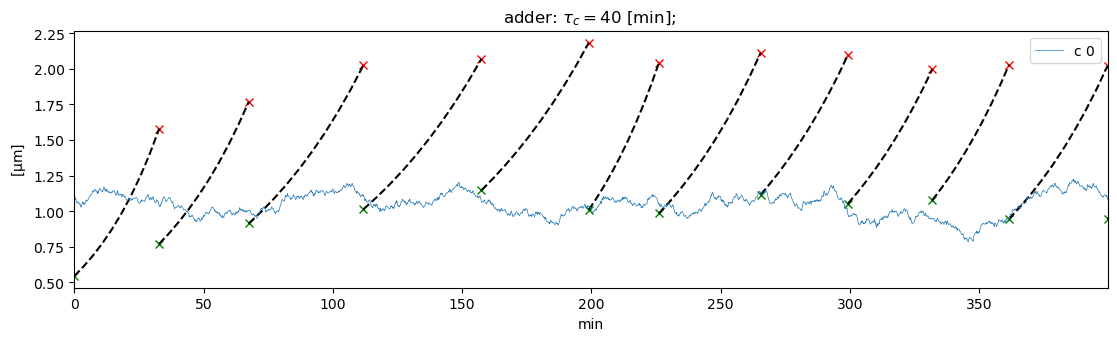

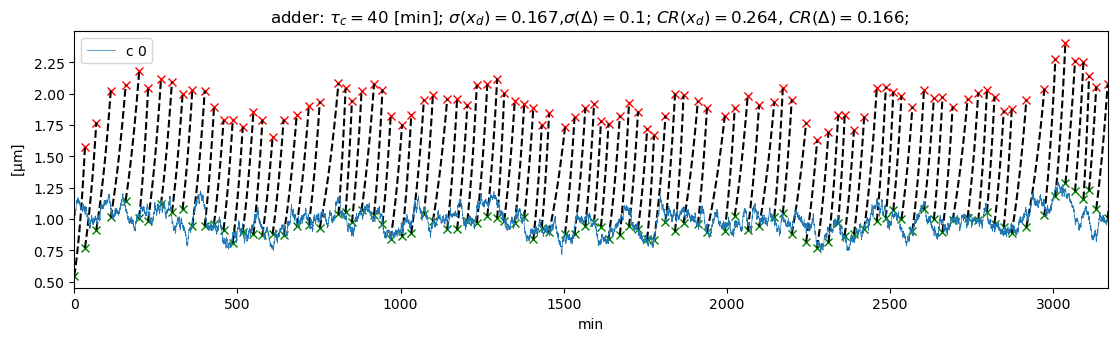

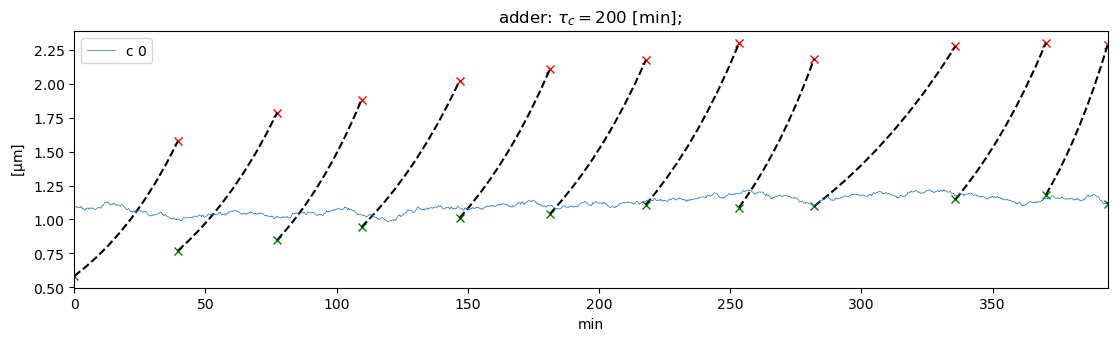

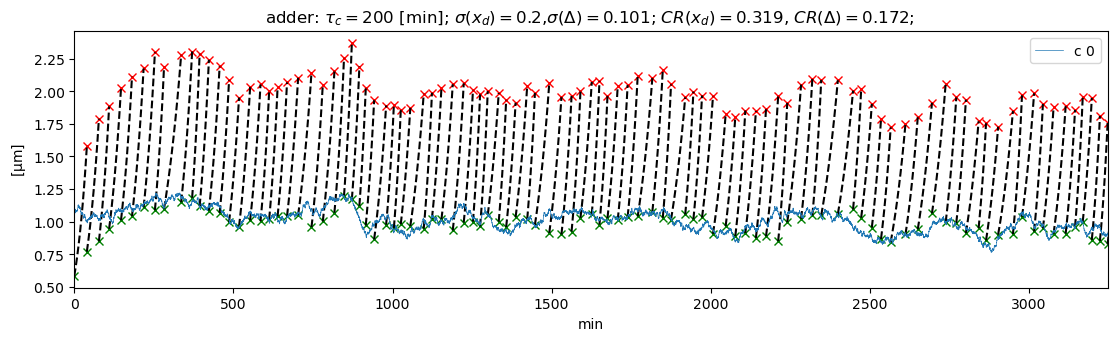

In [ ]:
def get_CR_str(observations):
  xb, xd = observations[:,:,0], observations[:,:,1]
  Delta = observations[:,:,1] - observations[:,:,0]
  T = observations[:,:,2]

  observations_alpha = observations.copy()
  observations_alpha[:,:,1] = 1/T*np.log(xd/xb)


  shuffledObservations_alpha = observations_alpha.copy()
  for p in range(shuffledObservations_alpha.shape[0]):
    for t in range(shuffledObservations_alpha.shape[1]):
      for f in range(shuffledObservations_alpha.shape[2]):
        shuffledObservations_alpha[p,t,f] = shuffledObservations_alpha[np.random.randint(shuffledObservations_alpha.shape[0]), np.random.randint(shuffledObservations_alpha.shape[1]), f]

  xb_shuffled, alpha_shuffled, T_shuffled = shuffledObservations_alpha[:,:,0], shuffledObservations_alpha[:,:,1], shuffledObservations_alpha[:,:,2]
  xd_shuffled = xb_shuffled*np.exp(alpha_shuffled*T_shuffled)
  Delta_shuffled = xd_shuffled - xb_shuffled

  CR_xd = xd.std()/xd_shuffled.std()
  CR_Delta = Delta.std()/Delta_shuffled.std()

  CR_str = r'; $CR(x_d)=$' + f'{str(round(CR_xd, 3))}' + r', $CR(\Delta)=$' + f'{str(round(CR_Delta, 3))}; '
  return CR_str

def plot_cs_and_lineage(ts, samples, observations, xlabel, ylabel, title=''):
    samples = np.transpose(samples[:,:,0])
    plt.figure(figsize=(20/1.5,5/1.5))
    for i, sample in enumerate(samples):
        singleLineageObservations = observations[i]
        t_xb = np.concatenate((np.zeros((1,)), singleLineageObservations[:,2].cumsum()))[:-1]
        t_xd = singleLineageObservations[:,2].cumsum()
        xb = singleLineageObservations[:,0]
        xd = singleLineageObservations[:,1]
        tIndices = t_xb < ts[-1]
        t_xb, t_xd, xb, xd = t_xb[tIndices], t_xd[tIndices], xb[tIndices], xd[tIndices]
        plt.plot(t_xb, xb, 'xg')
        plt.plot(t_xd, xd, 'xr')
        for t_xb_idx in range(len(t_xb)):
            T = t_xd[t_xb_idx] - t_xb[t_xb_idx]
            alpha = 1/T*np.log(xd[t_xb_idx]/xb[t_xb_idx])
            tVec = np.linspace(t_xb[t_xb_idx], t_xd[t_xb_idx], 10)
            xVals = xb[t_xb_idx]*np.exp(alpha*(tVec-tVec[0]))
            plt.plot(tVec, xVals, '--k')
        plt.plot(ts, sample[:len(ts)], linewidth = 0.5, label=f'c {i}')
    plt.title(title)



    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([t_xb[0], t_xb[-1]])
    plt.legend()
    plt.show()

def getKuheliData(df):
    indices = np.where(df['birth size (um)']>0)[0]
    xb = df.iloc[indices]['birth size (um)'].to_numpy()
    T = df.iloc[indices]['division time (min)'].to_numpy()
    indices = np.where(df['division size (um)']>0)[0]
    xd = df.iloc[indices]['division size (um)'].to_numpy()
    return np.reshape(np.concatenate((xb[:,None], xd[:,None], T[:,None]), axis=1), (100,100,3))


runOnKuheliData = False
if runOnKuheliData:
    observations_sizer = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_sizer.csv'))
    observations_adder = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_adder.csv'))
    observations_timer = getKuheliData(pd.read_csv('/Users/ron.teichner/Dropbox (Technion Dropbox)/KuheliBacteria/datasets for paper/Synthetic_data/cell size threshold: x(t)/cell_size_timer.csv'))


sizerMechnismList = [observations_sizer, observations_adder, observations_timer]
adderMechanismList = [observations_adder_small_tau, observations_adder_medium_tau, observations_adder_high_tau]

for observationList,mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    for observations, ouProcess, csi in zip(observationList, [cs_sizer, cs_adder, cs_timer], np.arange(len(tau_cs)).tolist()):
        titleStr = mechanismType + r': $\tau_c=$' + f'{tau_cs[csi]} [min]; '
        plot_cs_and_lineage(ts[:int(nMin2Plot/t_step)], ouProcess[:,:1], observations[:1], xlabel='min', ylabel='$\mathrm{[\mu m]}$', title=titleStr)
        titleStr = mechanismType + r': $\tau_c=$' + f'{tau_cs[csi]} [min]; ' + r'$\sigma(x_d)=$' + f'{str(round(observations[:,:,1].std(), 3))},' + r'$\sigma(\Delta)=$' + f'{str(round((observations[:,:,1]-observations[:,:,0]).std(), 3))}' + get_CR_str(observations)
        plot_cs_and_lineage(ts, ouProcess[:,:1], observations[:1], xlabel='min', ylabel='$\mathrm{[\mu m]}$', title=titleStr)



Analyzing the division mechanism using the $\Delta \overset{\Delta}{=} x_d-x_b$ vs $x_b$ correlation plot yields,

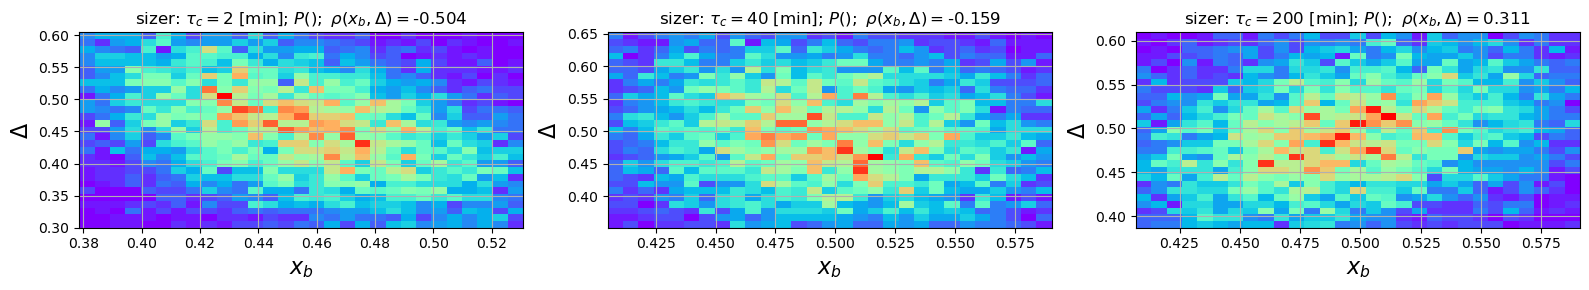

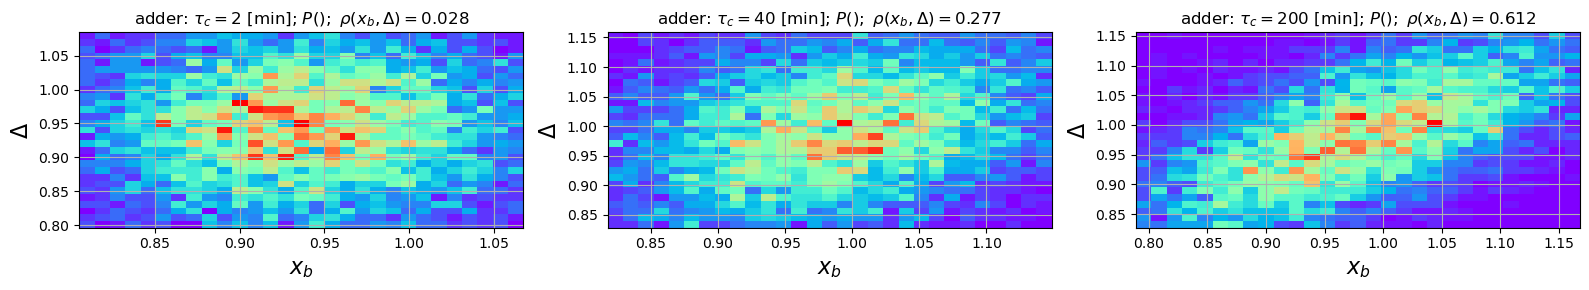

In [ ]:
import pandas as pd
axx,ab = 16/3, 9/3

sizerMechnismList = [observations_sizer, observations_adder, observations_timer]
adderMechanismList = [observations_adder_small_tau, observations_adder_medium_tau, observations_adder_high_tau]
for observationList, mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(axx*3,ab*1))
    for i,observations in enumerate(observationList):
      ax = axs[i]
      xb, xd = observations[:,:,0].flatten(), observations[:,:,1].flatten()
      xbMin, xbMax = np.quantile(xb, 5/100), np.quantile(xb, 95/100)
      xd_Minus_xbMin, xd_Minus_xbMax = np.quantile(xd-xb, 5/100), np.quantile(xd-xb, 95/100)
      H, xedges, yedges = np.histogram2d(xb, xd-xb, bins=(np.linspace(xbMin, xbMax, 30), np.linspace(xd_Minus_xbMin, xd_Minus_xbMax, 30)), density=True)#, density=True)
      # Histogram does not follow Cartesian convention (see Notes),
      # therefore transpose H for visualization purposes.
      H = H.T
      X, Y = np.meshgrid(xedges, yedges)
      im = ax.pcolormesh(X, Y, H, cmap='rainbow')
      #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
      corr = pd.Series(xb).corr(pd.Series(xd-xb))
      ax.set_xlim([xbMin, xbMax])
      ax.set_ylim([xd_Minus_xbMin, xd_Minus_xbMax])
      ax.set_xlabel(r'$x_b$',fontsize=16)
      ax.set_ylabel(r'$\Delta$',fontsize=16)
      ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(x_b,\Delta)=$' + f'{str(round(corr, 3))}')
      #plt.colorbar(im)
      ax.grid()


    fig.tight_layout()
    plt.show()





And analyzing using mother-daughter correlation plots yields:

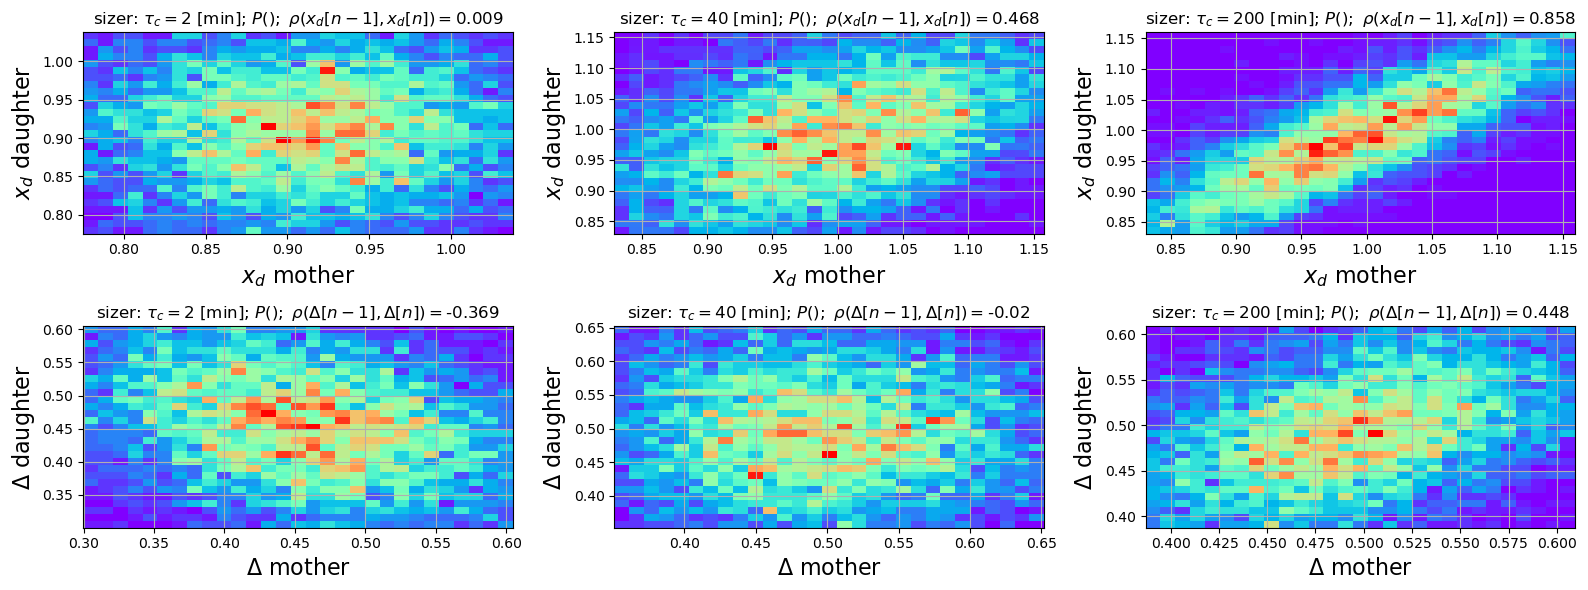

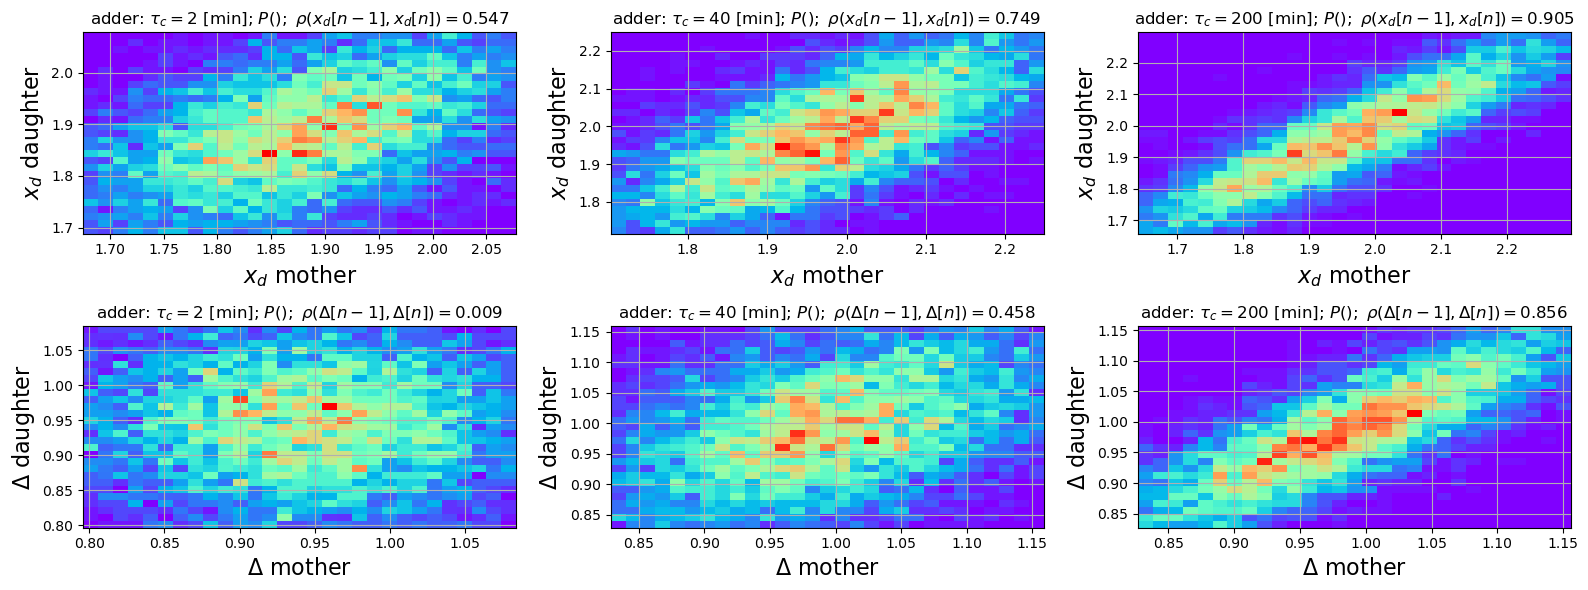

In [ ]:
for observationList, mechanismType in zip([sizerMechnismList, adderMechanismList], ['sizer', 'adder']):
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=False, figsize=(axx*3,ab*2))
    for i,observations in enumerate(observationList):
        # calculate mother-daughter correlations:
        delta = observations[:,:,1:2] - observations[:,:,0:1]
        xd = observations[:,:,1:2]
        mother_daughter_delta = np.concatenate((delta[:, :-1], delta[:,1:]), axis=2)
        mother_daughter_xd = np.concatenate((xd[:, :-1], xd[:,1:]), axis=2)
        mother_delta, daughter_delta = mother_daughter_delta[:,:,0].flatten(), mother_daughter_delta[:,:,1].flatten()
        mother_xd, daughter_xd = mother_daughter_xd[:,:,0].flatten(), mother_daughter_xd[:,:,1].flatten()

        ax = axs[0,i]
        mother_xdMin, mother_xdMax = np.quantile(mother_xd, 5/100), np.quantile(mother_xd, 95/100)
        daughter_xdMin, daughter_xdMax = np.quantile(daughter_xd, 5/100), np.quantile(daughter_xd, 95/100)
        H, xedges, yedges = np.histogram2d(mother_xd, daughter_xd, bins=(np.linspace(mother_xdMin, mother_xdMax, 30), np.linspace(daughter_xdMin, daughter_xdMax, 30)), density=True)#, density=True)
        # Histogram does not follow Cartesian convention (see Notes),
        # therefore transpose H for visualization purposes.
        H = H.T
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X, Y, H, cmap='rainbow')
        #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
        corr = pd.Series(mother_xd).corr(pd.Series(daughter_xd))
        ax.set_xlim([mother_xdMin, mother_xdMax])
        ax.set_ylim([daughter_xdMin, daughter_xdMax])
        ax.set_xlabel(r'$x_d$ mother',fontsize=16)
        ax.set_ylabel(r'$x_d$ daughter',fontsize=16)
        ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(x_d[n-1],x_d[n])=$' + f'{str(round(corr, 3))}')
        #plt.colorbar(im)
        ax.grid()

        ax = axs[1,i]
        mother_deltaMin, mother_deltaMax = np.quantile(mother_delta, 5/100), np.quantile(mother_delta, 95/100)
        daughter_deltaMin, daughter_deltaMax = np.quantile(daughter_delta, 5/100), np.quantile(daughter_delta, 95/100)
        H, xedges, yedges = np.histogram2d(mother_delta, daughter_delta, bins=(np.linspace(mother_deltaMin, mother_deltaMax, 30), np.linspace(daughter_deltaMin, daughter_deltaMax, 30)), density=True)#, density=True)
        # Histogram does not follow Cartesian convention (see Notes),
        # therefore transpose H for visualization purposes.
        H = H.T
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X, Y, H, cmap='rainbow')
        #ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
        corr = pd.Series(mother_delta).corr(pd.Series(daughter_delta))
        ax.set_xlim([mother_deltaMin, mother_deltaMax])
        ax.set_ylim([daughter_deltaMin, daughter_deltaMax])
        ax.set_xlabel(r'$\Delta$ mother',fontsize=16)
        ax.set_ylabel(r'$\Delta$ daughter',fontsize=16)
        ax.set_title(mechanismType + r': $\tau_c=$' + f'{tau_cs[i]} [min]; ' + r'$P();$' + r' $\rho(\Delta[n-1],\Delta[n])=$' + f'{str(round(corr, 3))}')
        #plt.colorbar(im)
        ax.grid()

    fig.tight_layout()
    plt.show()

We clearly see that although the division mechanism is a sizer, the different $\tau_c$ values affect the correlation plot and leads to false identification of the division mechanism (The color represents the 2D histogram values).

Next we analyze the division mechanism using the IRAS algorithm. For identifying the division mechanism we run IRAS on the transformed features, $z_n^{(l)} = \left(x_{n,b}^{(l)}, \alpha_n^{(l)} \overset{\Delta}{=} \frac{1}{T_n^{(l)}}\log\left(\frac{x_{n,d}^{(l)}}{x_{n,b}^{(l)}}\right),T_n^{(l)}\right)$.

## Define the neural-network $g(z)$ (combination player), the shuffle player and the Coefficient of Regulation loss
Next we define


1.   The combination player as a neural-network $g: \mathbb{R}^3 → \mathbb{R}$ that will output a combination $r = g(z)$ for each observation $z$.
2.   The shuffle player that assigns each element in the naive-shuffled ensemble $\bar{z}$ the probability of including it in the constrained-shuffled ensemble $\tilde{z}$. The shuffle player assigns the probability via the resampling function $\zeta(\cdot)$ such that it minimizes the objective,
$$
\begin{equation}
\begin{split}
&\min_{\zeta} D(P_z(g(z),P_{\tilde{z}}(g(\tilde{z})))\\
&\text{s.t } \tilde{z} \sim P_{\tilde{z}}(g(\tilde{z}))=P_{\bar{z}}(g(\tilde{z}))\zeta(g(\tilde{z}))
\end{split}
\end{equation}
$$
3.   The minimization objective of the combination player which is the Coefficient of Regulation with respect to the constrained shuffled ensemble,
$$
\begin{equation}
  min_g\frac{\sigma\left(r \sim P_z(g(z))\right)}{\sigma\left(\tilde{r} \sim P_{\tilde{z}}(g(\tilde{z})))\right)}.
\end{equation}
$$





In [ ]:
import torch
import torch.nn as nn


class Combination_ANN(nn.Module):
  def __init__(self, mu, Sigma_minus_half, features2ShuffleTogether, transform, playerPerPatient):
        super(Combination_ANN, self).__init__()
        if transform == 'randomMatrix':
          self.inputDim = 3*2
        else:
          self.inputDim = 3*3
        self.shuffleFactor = 100
        self.Sigma_minus_half = nn.parameter.Parameter(torch.tensor(Sigma_minus_half, dtype=torch.float), requires_grad=False)
        self.mu = nn.parameter.Parameter(torch.tensor(mu, dtype=torch.float), requires_grad=False)
        self.features2ShuffleTogetherLists = features2ShuffleTogether
        self.playerPerPatient = playerPerPatient

        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 64),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(64, 32),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.LeakyReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())
        '''
        self.sequence = nn.Sequential(nn.Linear(self.inputDim, 32),
                                                  nn.ReLU(),
                                                  #nn.Linear(64, 32),
                                                  #nn.ReLU(),
                                                  nn.Linear(32, 16),
                                                  nn.ReLU(),
                                                  nn.Linear(16, 1),
                                                  nn.Sigmoid())
        '''
  def shuffle(self, observations):
    naiveShuffledObservations = torch.zeros_like(observations)
    if not self.playerPerPatient:
      for features2ShuffleTogether in self.features2ShuffleTogetherLists:
        permuteSystemIdx = torch.randperm(observations.shape[0])#torch.randint_like(input=observations, low=0, high=observations.shape[0], dtype=torch.int64)
        permuteTimeIdx = torch.randperm(observations.shape[1])#torch.randint_like(input=observations, low=0, high=observations.shape[1], dtype=torch.int64)

        systemPermutedObservations = observations[permuteSystemIdx]#torch.gather(input=observations, dim=0, index=permuteSystemIdx)
        timeSystemPermutedObservations = systemPermutedObservations[:,permuteTimeIdx]#torch.gather(input=systemPermutedObservations, dim=1, index=permuteTimeIdx)
        naiveShuffledObservations[:,:,features2ShuffleTogether] = timeSystemPermutedObservations[:,:,features2ShuffleTogether]
    else:
      for s in range(observations.shape[0]):
        for features2ShuffleTogether in self.features2ShuffleTogetherLists:
          permuteIdx = torch.randperm(observations.shape[1])
          for f in features2ShuffleTogether:
            naiveShuffledObservations[s,:,f] = observations[s,permuteIdx,f]


    return naiveShuffledObservations

  def multipleShuffles(self, observations):
    naiveShuffledObservations = torch.zeros((observations.shape[0], int(observations.shape[1]*self.shuffleFactor), observations.shape[2]), dtype=torch.float, device=observations.device)
    for sf in range(self.shuffleFactor):
      naiveShuffledObservations[:,sf*observations.shape[1]:(sf+1)*observations.shape[1]] = self.shuffle(observations)
    return naiveShuffledObservations

  def normalizeObservations(self, observations):
    nSystem = observations.shape[0]
    nTime = observations.shape[1]
    means = self.mu[None, None, :, :].expand(nSystem, nTime, -1, -1)
    Sigma_minus_half = self.Sigma_minus_half[None, None, :, :].expand(nSystem, nTime, -1, -1)
    tilde_z = observations[:, :, :, None]
    nan_indices = tilde_z.isnan()
    tilde_z[nan_indices] = torch.zeros_like(tilde_z[nan_indices])
    normalized_tilde_z = torch.matmul(Sigma_minus_half, tilde_z - means)
    normalized_tilde_z[nan_indices] = torch.nan
    normalized_tilde_z = normalized_tilde_z[:,:,:, 0]

    return normalized_tilde_z

  def forward(self, observations):
    naiveShuffledObservations = self.multipleShuffles(observations)
    combination = self.sequence(self.normalizeObservations(observations))
    combinationOnNaiveShuffle = self.sequence(self.normalizeObservations(naiveShuffledObservations))
    return combination, combinationOnNaiveShuffle, naiveShuffledObservations

def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

def shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient):

  device = combination.device
  combination, combinationOnNaiveShuffle = combination.detach(), combinationOnNaiveShuffle.detach()
  nBins = 50
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]

  if not(playerPerPatient):
    comb_data_flatten, comb_shuffle_flatten = torch.zeros((0), dtype=torch.float, device=combination.device), torch.zeros((0), dtype=torch.float, device=combination.device)

    for p in range(nSystems):
        comb_data_flatten_singlePatient = combination[p, :, 0]
        comb_data_flatten = torch.cat((comb_data_flatten, comb_data_flatten_singlePatient))

        comb_shuffle_flatten_singlePatient = torch.zeros((0), dtype=torch.float, device=combination.device)
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + baseLength
            comb_shuffle_flatten_singleShuffle = combinationOnNaiveShuffle[p, start:stop, 0]
            comb_shuffle_flatten_singlePatient = torch.cat((comb_shuffle_flatten_singlePatient, comb_shuffle_flatten_singleShuffle))
        comb_shuffle_flatten = torch.cat((comb_shuffle_flatten, comb_shuffle_flatten_singlePatient))


    min_range = comb_data_flatten.min()
    max_range = comb_data_flatten.max()

    bins = torch.linspace(min_range, max_range, nBins, device='cpu')
    prob_data = torch.histogram(comb_data_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]
    prob_shuffle = torch.histogram(comb_shuffle_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]

    binsDict = {'bins': bins, 'minVal': min_range, 'maxVal': max_range}
  else:
    binsDict, prob_data, prob_shuffle = list(), list(), list()
    for p in range(nSystems):
      comb_data_flatten_singleSystem = combination[p, :, 0]

      systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combination.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combination.device)[None, :].repeat(baseLength, 1)).flatten()
      comb_shuffle_flatten_singleSystem = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices)

      min_range = comb_data_flatten_singleSystem.min()
      max_range = comb_data_flatten_singleSystem.max()

      bins = torch.linspace(min_range, max_range, nBins, device='cpu')
      prob_data_patient = torch.histogram(comb_data_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]
      prob_shuffle_patient = torch.histogram(comb_shuffle_flatten_singleSystem.to('cpu'), bins=bins.to('cpu'), density=True)[0]

      if prob_data_patient.isnan().any():
        prob_data.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_data.append(prob_data_patient)

      if prob_shuffle_patient.isnan().any():
        prob_shuffle.append(torch.ones_like(bins[:-1].to('cpu')) / bins[:-1].shape[0])
      else:
        prob_shuffle.append(prob_shuffle_patient)

      binsDict.append({'bins': bins, 'minVal': min_range, 'maxVal': max_range})


  prob_data, prob_shuffle, binsDict = move_to(prob_data, device), move_to(prob_shuffle, device), move_to(binsDict, device)
  combination, combinationOnNaiveShuffle = combination.to(device), combinationOnNaiveShuffle.to(device)
  combinationOnNaiveShuffle_selectionProb = torch.zeros_like(combinationOnNaiveShuffle)

  if not(playerPerPatient):
    bins, minVal, maxVal = binsDict['bins'], binsDict['minVal'], binsDict['maxVal']
    prob_select = torch.zeros_like(prob_data)
    posProbInx = prob_shuffle > 0
    prob_select[posProbInx] = prob_data[posProbInx]/prob_shuffle[posProbInx]
    prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

    validIndices = torch.zeros_like(combinationOnNaiveShuffle, device=combinationOnNaiveShuffle.device).bool()

    for p in range(nSystems):
        lengthOfCurrentSeries = baseLength
        for s in range(shuffleFactor):
            start = s*baseLength
            stop = start + lengthOfCurrentSeries
            validIndices[p, start:stop] = True

    validIndices[combinationOnNaiveShuffle < minVal] = False
    validIndices[combinationOnNaiveShuffle > maxVal] = False

    bin_belong = torch.zeros_like(combinationOnNaiveShuffle, dtype=torch.long, device=combinationOnNaiveShuffle.device)
    for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle >= bins[b]] = b

    combinationOnNaiveShuffle_selectionProb = prob_select[bin_belong]
    combinationOnNaiveShuffle_selectionProb[torch.logical_not(validIndices)] = 0
  else:
    for p in range(nSystems):
      bins, minVal, maxVal = binsDict[p]['bins'], binsDict[p]['minVal'], binsDict[p]['maxVal']

      prob_select = torch.zeros_like(prob_data[p])
      posProbInx = prob_shuffle[p] > 0
      prob_select[posProbInx] = prob_data[p][posProbInx]/prob_shuffle[p][posProbInx]
      prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

      validIndices = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], device=combinationOnNaiveShuffle.device).bool()

      for s in range(shuffleFactor):
        start = s*baseLength
        stop = start + baseLength
        validIndices[0, start:stop] = True

      validIndices[combinationOnNaiveShuffle[p:p+1] < minVal] = False
      validIndices[combinationOnNaiveShuffle[p:p+1] > maxVal] = False

      bin_belong = torch.zeros_like(combinationOnNaiveShuffle[p:p+1], dtype=torch.long, device=combinationOnNaiveShuffle.device)

      for b in range(bins.shape[0]-1):
        bin_belong[combinationOnNaiveShuffle[p:p+1] >= bins[b]] = b

      combinationOnNaiveShuffle_selectionProb[p] = prob_select[bin_belong][0]
      combinationOnNaiveShuffle_selectionProb[p][torch.logical_not(validIndices)[0]] = 0

  return combinationOnNaiveShuffle_selectionProb

def CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient):
  #playerPerPatient = False
  shuffleFactor = int(combinationOnNaiveShuffle.shape[1]/combination.shape[1])
  baseLength = combination.shape[1]
  nSystems = combination.shape[0]
  totalSeriesLengths  = int(nSystems*baseLength)
  totalShuffleSeriesLengths  = totalSeriesLengths*shuffleFactor

  combinationStds, combinationOnShuffledStds, combinationOnNaiveShuffledStds = torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device), torch.zeros((nSystems), dtype=torch.float, device=combination.device)
  selectedShuffleCombinations = torch.zeros((0), dtype=torch.float, device=combination.device)

  combinationIndices = torch.zeros((totalSeriesLengths), dtype=torch.long, device=combination.device)
  systemCombinationsStartIdx = 0
  for p in range(nSystems):
    combinationIndices[systemCombinationsStartIdx:systemCombinationsStartIdx+baseLength] = torch.arange(baseLength) + baseLength*p
    systemCombinationsStartIdx += baseLength

  systemCombinations = torch.gather(combination.flatten(), 0, combinationIndices)
  naiveShuffleCombinations = torch.zeros((totalShuffleSeriesLengths), dtype=torch.float, device=systemCombinations.device)
  systemCombinationsStartIdx = 0

  for p in range(nSystems):
    systemCombination = combination[p:p + 1]
    systemShuffledCombinationProbIndices = (torch.arange(baseLength, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[:, None].repeat(1, shuffleFactor) + baseLength*torch.arange(shuffleFactor, dtype=torch.long, device=combinationOnNaiveShuffle_selectionProb.device)[None, :].repeat(baseLength, 1)).flatten()
    systemShuffledCombinationProb = torch.gather(combinationOnNaiveShuffle_selectionProb[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
    systemShuffledCombination = torch.gather(combinationOnNaiveShuffle[p,:,0], 0, systemShuffledCombinationProbIndices).unsqueeze(0).unsqueeze(2)
    combinationStds[p] = systemCombination.std()
    naiveShuffleCombinations[systemCombinationsStartIdx:systemCombinationsStartIdx+systemShuffledCombination.shape[1]] = systemShuffledCombination[0, :, 0]
    systemCombinationsStartIdx += systemShuffledCombination.shape[1]

    selection = torch.rand_like(systemShuffledCombinationProb) < systemShuffledCombinationProb
    selectedShuffleCombinationsSingleSystem = systemShuffledCombination[selection]
    selectedShuffleCombinations = torch.cat((selectedShuffleCombinations, selectedShuffleCombinationsSingleSystem))
    combinationOnNaiveShuffledStds[p] = systemShuffledCombination.std()
    if selection.sum() < 5:
      combinationOnShuffledStds[p] = 0
    else:
      combinationOnShuffledStds[p] = selectedShuffleCombinationsSingleSystem.std()

    if playerPerPatient:
      validPatientIndices = combinationOnShuffledStds > 0
      if validPatientIndices.any():
        stdRatios = torch.divide(combinationStds[validPatientIndices], combinationOnShuffledStds[validPatientIndices])
        CR = stdRatios.mean()

        stdRatios_naiveShuffle = torch.divide(combinationStds[validPatientIndices], combinationOnNaiveShuffledStds[validPatientIndices])
        CR_zeta1 = stdRatios_naiveShuffle.mean()
    else:
      CR = torch.divide(systemCombinations.std(), selectedShuffleCombinations.std())
      CR_zeta1 = torch.divide(systemCombinations.std(), naiveShuffleCombinations.std())

  return CR, CR_zeta1

def printShufflePlayerAndCombination(Data_init, Data_shuffle_init, std_data, mean_data, epoch, corrs, titleStr):

  init_mean= Data_init['comb'].mean()
  init_std = Data_init['comb'].std()
  Data_init.loc[:,'comb'] = (Data_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data
  Data_init.loc[:,'combGT'] = (Data_init['combGT'].to_numpy() - mean_data)/std_data*std_data + mean_data
  Data_shuffle_init.loc[:,'comb'] = (Data_shuffle_init['comb'].to_numpy() - init_mean)/init_std*std_data + mean_data



  plt.figure(figsize=(24/1.5,9/1.5/2))
  plt.suptitle(titleStr + f': Epoch {epoch}: ' + f'Pearson correlations (sizer, adder, timer) = ({str(round(np.abs(corrs[0]), 2))}, {str(round(np.abs(corrs[1]), 2))}, {str(round(np.abs(corrs[2]), 2))})')
  nBins = 16
  dataBoundaryColor = 'white'


  plt.subplot(1,3,1)
  plt.title('PDF')
  authenticCombValues = Data_init['comb']
  naiveCombValues = Data_shuffle_init['comb']
  selectionProb = Data_shuffle_init['ProbAssignedByPlayer']
  # create selected comb values:
  selectedCombValues = naiveCombValues[selectionProb > np.random.rand(naiveCombValues.shape[0])]
  min_range = authenticCombValues.min()
  max_range = authenticCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(authenticCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3,label=r'$P(g(Z))$')

  min_range = selectedCombValues.min()
  max_range = selectedCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(selectedCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dashed', label=r'$P(g(\tilde{Z}))$')

  min_range = naiveCombValues.min()
  max_range = naiveCombValues.max()
  bins = np.linspace(min_range, max_range, nBins)
  plt.hist(naiveCombValues,bins=bins,density=True,log=False,histtype='step',linewidth=3, linestyle='dotted', label=r'$P(g(\bar{Z}))$')

  #plt.axvline(authenticCombValues.min(), color='b', linewidth=1)
  #plt.axvline(authenticCombValues.max(), color='b', linewidth=1)#, label='D-b')
  #plt.ylabel(r'Iteration $0$',fontsize = 14)
  plt.xlabel('r',fontsize = 14)
  plt.legend(fontsize = 10, loc='upper left')
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 10)
  #plt.xlim([0,4])
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
  plt.tight_layout()

  plt.subplot(1,3,2)
  plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],Data_shuffle_init['ProbAssignedByPlayer'],20,cmap='plasma')
  plt.xlabel(r'$x_b$',fontsize=14)
  plt.ylabel(r'$T$',fontsize=14)
  plt.title("Probability of selection",fontsize=14)
  cbar=plt.colorbar()
  #cbar.ax.set_ylabel("Probability of selection",fontsize=14)
  v=np.arange(np.min(Data_shuffle_init['xb']),np.max(Data_shuffle_init['xb']),0.05)
  #plt.legend(ncol=2,fontsize=10)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 10)
  #plt.ylim([1.2,9])
  plt.tight_layout()

  plt.subplot(1,3,3)
  #vmin, vmax = -0.75, 4.5
  plt.title(r"$g(x_b,T)$",fontsize=14)
  plt.xlabel(r'$x_b$',fontsize=14)
  #d=reg.predict(Data_shuffle_init['comb'].array.reshape(-1,1))
  d=Data_shuffle_init['comb'].array.reshape(-1,1)
  plt.tricontourf(Data_shuffle_init['xb'],Data_shuffle_init['T'],d.reshape(-1),20)#,vmin=vmin,vmax=vmax)
  #plt.ylabel(r'$P_2$',fontsize=14)
  #cbar=plt.colorbar()
  #cbar.ax.set_ylabel(r"Two player $g(P_1,P_2)$",fontsize=14)
  #plt.legend(ncol=2,fontsize=10)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 10)
  plt.tight_layout()
  #plt.ylim([1.2,9])
  '''
  plt.subplot(4,1,4)
  a = Data_init['comb'][:100]
  b = Data_init['combGT'][:100]
  a = (a-a.mean())/a.std()
  b = (b-b.mean())/b.std()
  if corr < 0:
    a = -a
  plt.plot(a, label=r'$g(x_b,T)$')
  plt.plot(b, label=r'$x_d$')
  plt.legend(fontsize=14)
  plt.xlabel(f'Pearson correlation = {str(round(np.abs(corr), 2))}', fontsize=14)
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
  '''
  display.display(plt.gcf())
  display.clear_output(wait=True)

  plt.show()

import torch.optim as optim
from IPython import display
import pandas as pd
%matplotlib inline

def IRAS_train(observations, transform='none', titleStr=''):
  import pandas as pd

  # observations (xb,xd,T)
  xb, xd, T = observations[:,:,0], observations[:,:,1], observations[:,:,2]
  alpha = 1/T*np.log(xd/xb)
  mean_xb, mean_xd = xb.mean(), xd.mean()
  dxb = np.zeros_like(xb)
  #dxb[:,1:] = xb[:,1:] - 0.5*xd[:,:-1]
  #xb_wrt_mean_xb = mean_xb + dxb
  dxb[:,1:] = xb[:,1:]/xd[:,:-1]
  xb_wrt_mean_xb = dxb*mean_xd
  xd_wrt_mean_xb = xb_wrt_mean_xb*np.exp(alpha*T)

  hypotheses_regulations = np.zeros((observations.shape[0], observations.shape[1], 6)) # sizer, adder, timer, folder, alpha, log-sizer
  if transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
      hypotheses_regulations[:,:,0] = xd_wrt_mean_xb # sizer
      hypotheses_regulations[:,:,1] = xd_wrt_mean_xb - xb_wrt_mean_xb # adder
      hypotheses_regulations[:,:,2] = T # timer
      hypotheses_regulations[:,:,3] = xd_wrt_mean_xb/xb_wrt_mean_xb # folder
      hypotheses_regulations[:,:,4] = alpha # alpha
      hypotheses_regulations[:,:,5] = np.log(xd_wrt_mean_xb) # log-sizer
  else:
      hypotheses_regulations[:,:,0] = xd # sizer
      hypotheses_regulations[:,:,1] = xd - xb # adder
      hypotheses_regulations[:,:,2] = T # timer
      hypotheses_regulations[:,:,3] = xd/xb # folder
      hypotheses_regulations[:,:,4] = alpha # alpha
      hypotheses_regulations[:,:,5] = np.log(xd) # log-sizer

  pearsonCorr_sizer_adder = pd.Series(hypotheses_regulations[:,:,1].flatten()).corr(pd.Series(hypotheses_regulations[:,:,0].flatten()))


  if transform == 'alpha_insteadOf_xd':
    # transforming to alpha:
    observations[:,:,1] = alpha # xb,alpha,T
  elif transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
    # transforming to alpha:
    observations[:,:,1] = alpha # xb,alpha,T
    observations[:,:,0] = dxb
    observations = observations[:,1:] # dxb,alpha,T
    hypotheses_regulations = hypotheses_regulations[:,1:]
  elif transform == 'alpha_insteadOf_T':
    # transforming to alpha:
    observations[:,:,2] = alpha # xb,xd,alpha
  elif transform == 'none':
    None
  elif transform == 'randomMatrix':
    F = observations.shape[2]
    observations = (np.random.randn(F,F)@observations[:,:,:,None])[:,:,:,0]
  else:
    print('unkown transform')
    assert False


  if not transform == 'randomMatrix':
    observations = np.concatenate((observations, np.log(observations), 1/observations), axis=2)
    features2ShuffleTogether = [[0,3,6], [1,4,7], [2,5,8]]
  else:
    observations = np.concatenate((observations, 1/observations), axis=2)
    features2ShuffleTogether = [[0,2], [1,3], [2,4]]

  # saving some statistics for future normalization
  featureMean, featureStd = list(), list()
  for f in range(observations.shape[2]):
    featureValues = observations[:, :, f].flatten()
    featureValues_05, featureValues_95 = pd.Series(featureValues).quantile(0.05), pd.Series(featureValues).quantile(0.95)
    featureMean.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].mean())
    featureStd.append(featureValues[np.logical_and(featureValues >= featureValues_05, featureValues <= featureValues_95)].std())

  mu = np.asarray(featureMean)[:, None]
  stdsVec = np.asarray(featureStd)[:, None]
  stdsVec[stdsVec == 0] = 1

  Sigma_minus_half = np.diag(1/stdsVec[:,0])
  Sigma_half = np.diag(stdsVec[:,0])



  observations_torch = torch.from_numpy(observations).type(torch.float)
  hypotheses_regulations_torch = torch.from_numpy(hypotheses_regulations).type(torch.float)

  playerPerPatient = False
  combinationPlayer = Combination_ANN(mu, Sigma_minus_half, features2ShuffleTogether, transform, playerPerPatient=playerPerPatient)
  modelParams = combinationPlayer.parameters()
  optimizer = optim.SGD(modelParams, lr=0.01, momentum=0.9, weight_decay=0.001)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
  nEpochs = 200

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  combinationPlayer.to(device)

  observations_torch, hypotheses_regulations_torch = observations_torch.to(device), hypotheses_regulations_torch.to(device)

  print(f'Dataset contains {observations_torch.shape[0]} lineages, from each lineage a time-series of length {observations_torch.shape[1]} is observed, each observation contains {observations_torch.shape[2]} features')

  for epoch in range(nEpochs):
    optimizer.zero_grad()
    # combination player:
    combination, combinationOnNaiveShuffle, naiveShuffledObservations = combinationPlayer(observations_torch)
    # shuffle player:
    combinationOnNaiveShuffle_selectionProb = shufflePlayer(combination, combinationOnNaiveShuffle, playerPerPatient)
    # Coefficient of Regulation:
    CR, CR_zeta1 = CoefficientOfRegulation(combination, combinationOnNaiveShuffle, combinationOnNaiveShuffle_selectionProb, playerPerPatient)
    # update the combination player as to minimize the CR:
    CR.backward()
    optimizer.step()  # parameter update
    scheduler.step()

    pearsonCorr_sizer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,0].flatten()))
    pearsonCorr_adder = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,1].flatten()))
    pearsonCorr_timer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,2].flatten()))
    pearsonCorr_folder = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,3].flatten()))
    pearsonCorr_alpha = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,4].flatten()))
    pearsonCorr_log_sizer = pd.Series(combination.detach().cpu().flatten()).corr(pd.Series(hypotheses_regulations[:,:,5].flatten()))

    enableText = True
    if enableText:
      if transform == 'none':
        xb, xd, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
      elif transform == 'alpha_insteadOf_xd':
        xb, alpha, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
        xd = xb*np.exp(alpha*T)
      elif transform == 'alpha_insteadOf_T':
        xb, xd, alpha = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
      elif transform == 'alpha_insteadOf_xd_dxb_insteadOf_xb':
        dxb, alpha, T = observations_torch.detach().cpu().numpy()[:,:,0], observations_torch.detach().cpu().numpy()[:,:,1], observations_torch.detach().cpu().numpy()[:,:,2]
        xb = dxb*mean_xd
        xd = xb*np.exp(alpha*T)

      Delta = xd - xb

      plt.figure()
      plt.subplot(1,2,1)

      cm = combination.mean().detach().cpu().numpy()
      plt.scatter(x=combination.detach().cpu().numpy().flatten()-cm, y=Delta.flatten(), s=1)
      plt.xlabel('g()')
      plt.ylabel(r'$\Delta$')
      plt.grid()
      plt.tight_layout()
      plt.subplot(1,2,2)
      plt.scatter(x=combination.detach().cpu().numpy().flatten()-cm, y=xd.flatten(), s=1)
      plt.xlabel('g()')
      plt.ylabel(r'$x_d$')
      plt.grid()
      plt.tight_layout()
      plt.show()

      print(f'epoch {epoch}: CR(zeta=1) = {str(round(CR_zeta1.item(), 3))}, CR = {str(round(CR.item(), 3))}')
      print(f'Pearson correlation between sizer and adder hypotheses = {str(round(np.abs(pearsonCorr_sizer_adder), 3))}')
      if transform == 'randomMatrix':
        featureStr = 'A[xb,alpha,T]'
        print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      elif transform in {'alpha_insteadOf_xd', 'alpha_insteadOf_xd_dxb_insteadOf_xb'}:
        featureStr = 'dxb,alpha,T'
        print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      elif transform == 'alpha_insteadOf_T':
        featureStr = 'xb,xd,alpha'
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      elif transform == 'none':
        featureStr = 'xb,xd,T'
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and sizer hypothesis = {str(round(np.abs(pearsonCorr_sizer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and adder hypothesis = {str(round(np.abs(pearsonCorr_adder), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and timer hypothesis = {str(round(np.abs(pearsonCorr_timer), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and folder hypothesis = {str(round(np.abs(pearsonCorr_folder), 3))}')
        print(f'Pearson correlation between learned combination g('+featureStr+f') and alpha hypothesis = {str(round(np.abs(pearsonCorr_alpha), 3))}')
        #print(f'Pearson correlation between learned combination g('+featureStr+f') and log-sizer hypothesis = {str(round(np.abs(pearsonCorr_log_sizer), 3))}')
      display.clear_output(wait=True)


    else:
      authenticData = pd.DataFrame(columns=['xb','T','comb','combGT'], data=torch.cat((torch.reshape(observations_torch[0:1,:,[0,2]], (-1,2)), torch.reshape(combination[0:1], (-1,1)), torch.reshape(hypotheses_regulations_torch[0:1,:,0], (-1,1))), dim=1).detach().cpu().numpy())
      shuffledData = pd.DataFrame(columns=['xb','T','comb','ProbAssignedByPlayer'], data=torch.cat((torch.reshape(naiveShuffledObservations[0:1,:,[0,2]], (-1,2)), torch.reshape(combinationOnNaiveShuffle[0:1,:], (-1,1)), torch.reshape(combinationOnNaiveShuffle_selectionProb[0:1,:], (-1,1))), dim=1).detach().cpu().numpy())
      printShufflePlayerAndCombination(authenticData, shuffledData, hypotheses_regulations[:,:,0].flatten().std(), hypotheses_regulations[:,:,0].flatten().mean(), epoch, [pearsonCorr_sizer, pearsonCorr_adder, pearsonCorr_timer], titleStr)










# Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=2$

We train the combination player on inputs originated from the observations and inputs generated by the shuffle player. The combination player's objective is to minimize the CR. It is trained using the SGD optimizer.

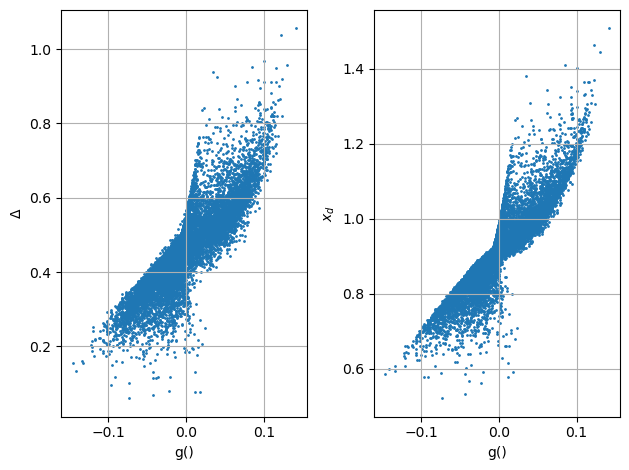

epoch 199: CR(zeta=1) = 0.554, CR = 0.998
Pearson correlation between sizer and adder hypotheses = 0.942
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.907
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.862
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.788
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.904


In [ ]:
IRAS_train(observations_sizer[:100].copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[0]}')

# Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=40$


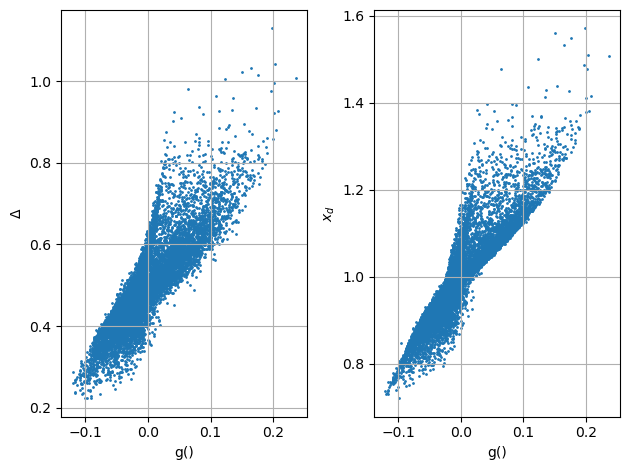

epoch 199: CR(zeta=1) = 0.443, CR = 0.998
Pearson correlation between sizer and adder hypotheses = 0.931
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.903
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.861
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.779
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.903


In [ ]:
IRAS_train(observations_adder.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[1]}')

# Evaluating IRAS algorithm on synthetic cell-size data with $\tau_c=200$


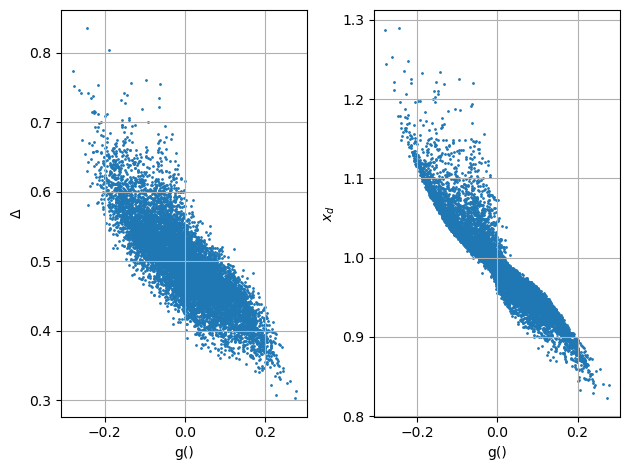

epoch 199: CR(zeta=1) = 0.379, CR = 0.997
Pearson correlation between sizer and adder hypotheses = 0.898
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.932
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.822
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.645
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.938


In [ ]:
IRAS_train(observations_timer.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[2]}')

# Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=2$

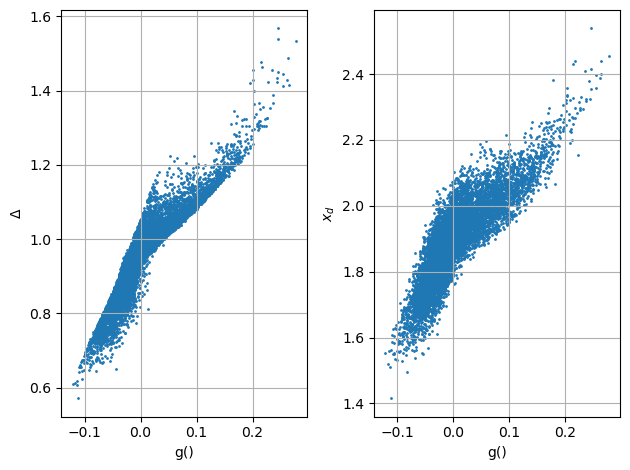

epoch 199: CR(zeta=1) = 0.309, CR = 1.0
Pearson correlation between sizer and adder hypotheses = 0.925
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.851
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.917
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.837
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.84


In [ ]:
IRAS_train(observations_adder_small_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[0]}')

# Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=40$


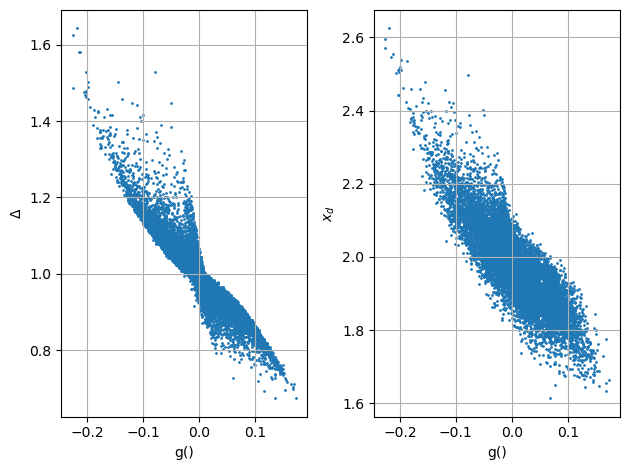

epoch 199: CR(zeta=1) = 0.33, CR = 0.998
Pearson correlation between sizer and adder hypotheses = 0.925
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.853
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.933
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.845
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.854


In [ ]:
IRAS_train(observations_adder_medium_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[1]}')

# Evaluating IRAS algorithm on synthetic added-size data with $\tau_c=200$


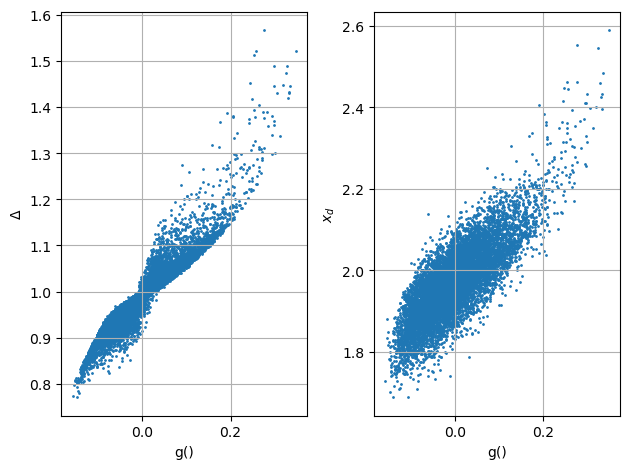

epoch 199: CR(zeta=1) = 0.293, CR = 1.001
Pearson correlation between sizer and adder hypotheses = 0.934
Pearson correlation between learned combination g(dxb,alpha,T) and sizer hypothesis = 0.805
Pearson correlation between learned combination g(dxb,alpha,T) and adder hypothesis = 0.945
Pearson correlation between learned combination g(dxb,alpha,T) and folder hypothesis = 0.774
Pearson correlation between learned combination g(dxb,alpha,T) and log-sizer hypothesis = 0.802


In [ ]:
IRAS_train(observations_adder_high_tau.copy(), 'alpha_insteadOf_xd_dxb_insteadOf_xb', r'$\tau_c = $' + f'{tau_cs[2]}')